# **Setup**

In [33]:
import pandas as pd
import numpy as np
from datetime import datetime
import random
import math

# Plot
import matplotlib.pyplot as plt
# Data source
import yfinance as yf
# Candlestick chart
import plotly.graph_objects as go 

# **Multiple Assets of Our Choice**

In [30]:
# The stocks we will use for analysis
stock_list = ['GOOG', 'MSFT']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)
for stock in stock_list:
  # Use the yf.download() function to download historical stock price data for the specified stock.
  globals()[stock] = yf.download(stock, start, end)
  # Store each stock data downloaded from Yahoo Finance in global variables named GOOG and MSFT.
  # Contains information such as ticker symbol, date, opening price, closing price, high price, low price, volume and adjusted closing price.

# Paired together via zip() function
company_list = [GOOG, MSFT]
company_name = ["GOOGLE", "MICROSOFT"]
for company, com_name in zip(company_list, company_name):
  company["company_name"] = com_name

# Showing last 10 data
df = pd.concat(company_list, axis=0)
df.tail(10)

# Upon examining the data, it is evident that the data is numerical and the date serves as the index. 
# Furthermore, it is observed that the records do not include data for weekends.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2023-04-19,285.989990,289.049988,284.540009,288.450012,288.450012,17150300,MICROSOFT
2023-04-20,285.250000,289.029999,285.079987,286.109985,286.109985,23244400,MICROSOFT
2023-04-21,285.010010,286.269989,283.059998,285.760010,285.760010,21665400,MICROSOFT
2023-04-24,282.089996,284.950012,278.720001,281.769989,281.769989,26611000,MICROSOFT
2023-04-25,279.510010,281.600006,275.369995,275.420013,275.420013,45772200,MICROSOFT
2023-04-26,296.700012,299.570007,292.730011,295.369995,295.369995,64599200,MICROSOFT
2023-04-27,295.970001,305.200012,295.250000,304.829987,304.829987,46462600,MICROSOFT
2023-04-28,304.010010,308.929993,303.309998,307.260010,307.260010,36446700,MICROSOFT
2023-05-01,306.970001,308.600006,305.149994,305.559998,305.559998,21275000,MICROSOFT


<Axes: title={'center': 'Normalize Value'}, xlabel='Date'>

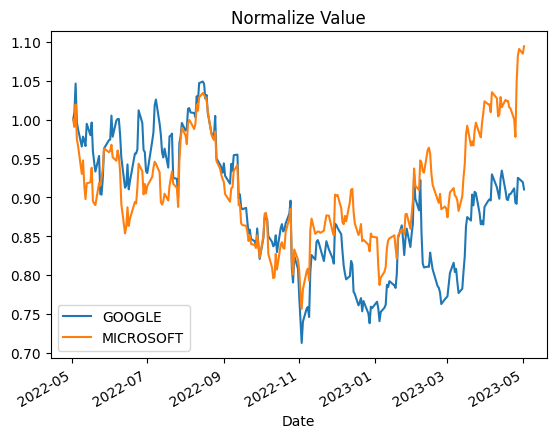

In [31]:
# Normalize Value

# Prepare DataFrame to store our results
combine_normalizeValue = pd.DataFrame(index=company_list[0].index, columns=company_name)

# Stocks For Loops
for company, com_name in zip(company_list, company_name):
  company['normalize_value'] = company['Adj Close']/company.iloc[0]['Adj Close']
  combine_normalizeValue[com_name] = company['normalize_value']

# Showing the plot
combine_normalizeValue.plot(title='Normalize Value')

# **Algorithmic Trading**

**Comparison of our algorithm with existing algorithms on signaling criteria**


---


Moving Average based approaches
*   The concept is that prices follow a pattern where they either rise or fall continuously over a period of time.

*   If the price rises above its average value, indicating that recent prices are higher than earlier ones, it suggests an upward trend and triggers a signal to buy.

*   Conversely, if the price falls below its average value, indicating that recent prices are lower than earlier ones, it suggests a downward trend and triggers a signal to sell.

*   The recommended action to take after receiving a buy signal is to purchase, while after receiving a sell signal, the recommended action is to sell.

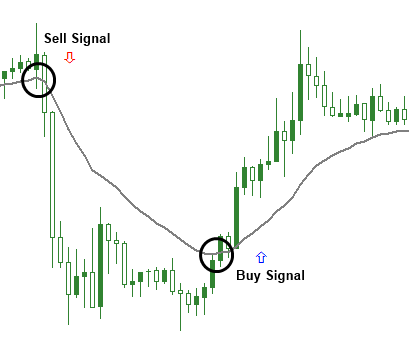

---


RSI based approaches

*   The relative strength index (RSI) provides short-term buy and sell signals. 
*   Low RSI levels (below 30) generate buy signals. 
*   High RSI levels (above 70) generate sell signals.



---


MA Crossover

- A sell/buy signal is generated when a short moving average crosses below/above a long moving average.
- A golden cross indicates a sustained uptrend in the market over the long term, while a death cross indicates a sustained downtrend.
- The significance of either cross is greater when trading volume is high.
- After the crossover, the long-term moving average becomes an important support level (for the golden cross) or resistance level (for the death cross) for the market going forward.
- Although either cross can signal a change in trend, they are more commonly seen as a strong confirmation of a trend change that has already occurred.
- Traders utilize both death crosses and golden crosses as tools to decide when to buy or sell an asset.


---



**Existing approach**


---


RSI

In [43]:
# Define a Relative Strength Index (RSI) trading strategy
def rsi_strategy(df, days, rsi_period=14, rsi_lower=30, rsi_upper=70):
    # Compute RSI
    delta = df['Adj Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(rsi_period).mean()
    avg_loss = loss.rolling(rsi_period).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Generate buy/sell signals
    # Go long (+1) when current RSI is below the rsi_lower. 
    # Go short (-1) when current RSI is above the rsi_lower.
    # 0 when RSI is not below/above the rsi_lower.
    df['signal'] = 0
    df['signal'][rsi_period:] = np.where(df['RSI'][rsi_period:] < rsi_lower, 1, np.where(df['RSI'][rsi_period:] > rsi_upper, -1, 0))
    df['position'] = df['signal'].shift(1) # shift(): Shift index by desired number of periods with an optional time freq

    # Compute daily returns
    df['returns'] = df['Adj Close'].pct_change() # pct_change(): Computes the percentage change from the immediately previous row by default
    df['strategy_returns'] = df['returns'] * df['position']

    # Compute performance metrics
    std_dev = df['strategy_returns'].std()
    simple_return = (df['Adj Close'][-1] - df['Adj Close'][0]) / df['Adj Close'][0]
    sharpe_ratio = (days**0.5) * df['strategy_returns'].mean() / std_dev
    profit = (1 + df['strategy_returns'].cumsum()[-1] * 100)
    max_drawdown = (df['strategy_returns'].cumsum().expanding().max() - df['strategy_returns'].cumsum()).max()
    log_return = np.log(df['Adj Close'][-1] / df['Adj Close'][0])

    return df, std_dev, simple_return, sharpe_ratio, profit, max_drawdown, log_return

# Prepare DataFrames to store our results
combine_rsi = pd.DataFrame(index=company_name, columns=['std_dev', 'simple_return', 'sharpe_ratio', 'profit', 'max_drawdown', 'log_return'])
combine_rsi_50d = pd.DataFrame(index=company_name, columns=['std_dev', 'simple_return', 'sharpe_ratio', 'profit', 'max_drawdown', 'log_return'])

######################################################################################################################################################

# Backtest the strategy
for company, com_name in zip(company_list, company_name):
  # Test from aggregate data and last 50 days of data
  for i, company in enumerate([company, company.tail(50)], 0):
    # If annual data
    if i == 0:
      com, std_dev, simple_return, sharpe_ratio, profit, max_drawdown, log_return = rsi_strategy(company, 252)
      # Store our results into our prepared DF
      combine_rsi['std_dev'][com_name] = std_dev
      combine_rsi['simple_return'][com_name] = simple_return
      combine_rsi['sharpe_ratio'][com_name] = sharpe_ratio
      combine_rsi['profit'][com_name] = profit
      combine_rsi['max_drawdown'][com_name] = max_drawdown
      combine_rsi['log_return'][com_name] = log_return
    # If 50 days data
    if i == 1:
      com, std_dev, simple_return, sharpe_ratio, profit, max_drawdown, log_return = rsi_strategy(company, 50)
      # Store our results into our prepared DF
      combine_rsi_50d['std_dev'][com_name] = std_dev
      combine_rsi_50d['simple_return'][com_name] = simple_return
      combine_rsi_50d['sharpe_ratio'][com_name] = sharpe_ratio
      combine_rsi_50d['profit'][com_name] = profit
      combine_rsi_50d['max_drawdown'][com_name] = max_drawdown
      combine_rsi_50d['log_return'][com_name] = log_return
    
    # Generate a candlestick chart with the trading signals
    fig = go.Figure(data=[go.Candlestick(
        x=com.index, open=com["Open"], high=com["High"],
        low=com["Low"], close=com["Adj Close"]),
        # Add Scatter plots
        # RSI
        go.Scatter(x=com.index, y=com['RSI'], name='RSI', line=dict(width=2)),
        # Buy/Sell positions
        go.Scatter(x=com.loc[com['position'] == 1].index, y=com['Adj Close'][com['position'] == 1],
                    name='Buy', mode='markers', marker=dict(size=7, color='green')),
        go.Scatter(x=com.loc[com['position'] == -1].index, y=com['Adj Close'][com['position'] == -1],
                    name='Sell', mode='markers', marker=dict(size=7, color='red'))
    ])
    fig.update_layout(
        title="{0} ({1} days)".format(com_name, len(com)),
        yaxis_title="{0} Candlestick Chart".format(com_name),
    )
    fig.show()

**Our Approaches**


---



Algo 1

*   Use 2 SMA long and SMA short
*   Go long when SMA_long is below the SMA_short
*   Go short when SMA_long is above the SMA_short

Algo 2

*   Use multiple MAs
*   Use multiple MAs crossovers instead of a single
*   Calculate the current total cumulative power of Golden Cross
*   Calculate the current total cumulative power of Death Cross
*   Calculate which crossover power is strong enough to generate a buy/sell signal

In [32]:
# For using .tail(50) to get last 50 days of data without warnings
pd.options.mode.chained_assignment = None  # default='warn'

def _sum(arr):
    # initialize a variable
    # to store the sum
    # while iterating through
    # the array later
    sum = 0
    # iterate through the array
    # and add each element to the sum variable
    # one at a time
    for i in arr:
        sum = sum + i
    return(sum)

**Algo 1**

In [34]:
# Define a Simple Moving Average (SMA) trading strategy
def moving_average_strategy(df, days, short_window=3, long_window=10):
  # Compute short and long moving averages
  df['SMA_short'] = df['Adj Close'].rolling(short_window).mean()
  df['SMA_long'] = df['Adj Close'].rolling(long_window).mean()
  
  # Generate buy/sell signals
  # Go long (+1) when SMA_long is above the SMA_short. 
  # Go short (-1) when SMA_long is below the SMA_short.
  df['signal'] = np.where(df['SMA_short'] > df['SMA_long'], 1, -1)
  df['position'] = df['signal'].shift(1) # shift(): Shift index by desired number of periods with an optional time freq
  
  # Compute cumulative returns
  df['returns'] = df['Adj Close'].pct_change() # pct_change(): Computes the percentage change from the immediately previous row by default
  # We only draw attention to when the price direction is changing, like SAR (Stop and Reverse System)
  # We need an array to store the cumulative returns for each trend
  thisTrend_returns_arr = []
  df['strategy_returns'] = 0
  same_singal_times = 0
  # Loop through all dates
  for i in range(len(df)):
    # Last one
    if df.index[i] == df.index[-1]:
      df['strategy_returns'][i] = _sum(thisTrend_returns_arr)
      thisTrend_returns_arr.clear()
    # If the buy/sell singal has not changed
    # The first ten do nothing, since the MA may not be initialized
    elif df['position'][i] == df['position'][i-1] and (df.index[i] != df.index[0:11]).any():
      if same_singal_times > 3:
        thisTrend_returns_arr.append(df['returns'][i])
      # For signal change times less than 3
      else:
        same_singal_times = same_singal_times + 1
    # If the buy/sell singal has changed
    # The first ten do nothing, since the MA may not be initialized
    elif df['position'][i] != df['position'][i-1] and (df.index[i] != df.index[0:11]).any():
      if same_singal_times > 3:
        df['strategy_returns'][i] = _sum(thisTrend_returns_arr)
        thisTrend_returns_arr.clear()
        same_singal_times = 0
      # For signal change times less than 3
      else:
        same_singal_times = 1

  # Compute performance metrics
  std_dev = df['strategy_returns'].std()
  simple_return = (df['Adj Close'][-1] - df['Adj Close'][0]) / df['Adj Close'][0]
  sharpe_ratio = (days**0.5) * df['strategy_returns'].mean() / std_dev
  profit = (1 + df['strategy_returns'].cumsum()[-1] * 100)
  max_drawdown = (df['strategy_returns'].cumsum().expanding().max() - df['strategy_returns'].cumsum()).max()
  log_return = np.log(df['Adj Close'][-1] / df['Adj Close'][0])
  
  return df, std_dev, simple_return, sharpe_ratio, profit, max_drawdown, log_return

# Prepare DataFrames to store our results
combine_algo1 = pd.DataFrame(index=company_name, columns=['std_dev', 'simple_return', 'sharpe_ratio', 'profit', 'max_drawdown', 'log_return'])
combine_algo1_50d = pd.DataFrame(index=company_name, columns=['std_dev', 'simple_return', 'sharpe_ratio', 'profit', 'max_drawdown', 'log_return'])

######################################################################################################################################################

# Backtest the strategy
for company, com_name in zip(company_list, company_name):
  # Test from aggregate data and last 50 days of data
  for i, company in enumerate([company, company.tail(50)], 0):
    # If annual data
    if i == 0:
      com, std_dev, simple_return, sharpe_ratio, profit, max_drawdown, log_return = moving_average_strategy(company, 252)
      # Store our results into our prepared DF
      combine_algo1['std_dev'][com_name] = std_dev
      combine_algo1['simple_return'][com_name] = simple_return
      combine_algo1['sharpe_ratio'][com_name] = sharpe_ratio
      combine_algo1['profit'][com_name] = profit
      combine_algo1['max_drawdown'][com_name] = max_drawdown
      combine_algo1['log_return'][com_name] = log_return
    # If 50 days data
    if i == 1:
      com, std_dev, simple_return, sharpe_ratio, profit, max_drawdown, log_return = moving_average_strategy(company, 50)
      # Store our results into our prepared DF
      combine_algo1_50d['std_dev'][com_name] = std_dev
      combine_algo1_50d['simple_return'][com_name] = simple_return
      combine_algo1_50d['sharpe_ratio'][com_name] = sharpe_ratio
      combine_algo1_50d['profit'][com_name] = profit
      combine_algo1_50d['max_drawdown'][com_name] = max_drawdown
      combine_algo1_50d['log_return'][com_name] = log_return
    
    # Generate a candlestick chart with the trading signals
    fig = go.Figure(data=[go.Candlestick(
        x=com.index, open=com["Open"], high=com["High"],
        low=com["Low"], close=com["Adj Close"]),
        # Add Scatter plots
        # SMA
        go.Scatter(x=com.index, y=com['SMA_short'], name='SMA_short', line=dict(width=2)),
        go.Scatter(x=com.index, y=com['SMA_long'], name='SMA_long', line=dict(width=2)),
        # Buy/Sell positions
        go.Scatter(x=com.loc[com['position'] == 1].index, y=com['Adj Close'][com['position'] == 1],
                    name='Buy', mode='markers', marker=dict(size=7, color='green')),
        go.Scatter(x=com.loc[com['position'] == -1].index, y=com['Adj Close'][com['position'] == -1],
                    name='Sell', mode='markers', marker=dict(size=7, color='red'))
    ])
    fig.update_layout(
        title="{0} ({1} days)".format(com_name, len(com)),
        yaxis_title="{0} Candlestick Chart".format(com_name),
    )
    fig.show()

**Algo 2**

In [35]:
# Define a Simple Moving Average (SMA) trading strategy
def crossover_strategy(df, days):
  # Compute short and long moving averages
  df['MA1'] = df['Adj Close'].rolling(1).mean()
  df['MA5'] = df['Adj Close'].rolling(5).mean()
  df['MA10'] = df['Adj Close'].rolling(10).mean()
  df['MA20'] = df['Adj Close'].rolling(20).mean()
  
  # Generate buy/sell signals
  df['signal'] = 0
  for i in range(len(df)):
    if df['MA1'][i] > df['MA5'][i] and df['MA1'][i] > df['MA10'][i] and df['MA1'][i] > df['MA20'][i]:
    # Go long (+1) when there are 2 golden crosses.
      df['signal'][i] = 1
    elif df['MA1'][i] < df['MA5'][i] and df['MA1'][i] < df['MA10'][i] and df['MA1'][i] < df['MA20'][i]:
    # Go short (-1) when there are 2 death crosses.
      df['signal'][i] = -1
    else:
      df['signal'][i] = 0

  df['position'] = df['signal'].shift(1) # shift(): Shift index by desired number of periods with an optional time freq
  
  # Compute cumulative returns
  df['returns'] = df['Adj Close'].pct_change() # pct_change(): Computes the percentage change from the immediately previous row by default
  # We only draw attention to when the price direction is changing, like SAR (Stop and Reverse System)
  # We need an array to store the cumulative returns for each trend
  thisTrend_returns_arr = []
  df['strategy_returns'] = 0
  # Loop through all dates
  for i in range(len(df)):
    # First one
    if df.index[i] == df.index[0]:
      thisTrend_returns_arr.append(df['returns'][i])
    # Last one
    elif df.index[i] == df.index[-1]:
      df['strategy_returns'][i] = _sum(thisTrend_returns_arr)
      thisTrend_returns_arr.clear()
    # If the buy/sell singal has not changed
    elif df['position'][i] == df['position'][i-1]:
      thisTrend_returns_arr.append(df['returns'][i])
    # If the buy/sell singal has changed
    elif df['position'][i] != df['position'][i-1] and df['position'][i-1] != 0:
      df['strategy_returns'][i] = _sum(thisTrend_returns_arr)
      thisTrend_returns_arr.clear()

  # To avoid false buy/sell signals from the beginning, we find the first non-zero value in df['strategy_returns'] and set it to 0
  non_zero_index = df['strategy_returns'].ne(0).idxmax()
  df['strategy_returns'][non_zero_index] = 0

  # Compute performance metrics
  std_dev = df['strategy_returns'].std()
  simple_return = (df['Adj Close'][-1] - df['Adj Close'][0]) / df['Adj Close'][0]
  sharpe_ratio = (days**0.5) * df['strategy_returns'].mean() / std_dev
  profit = (1 + df['strategy_returns'].cumsum()[-1] * 100)
  max_drawdown = (df['strategy_returns'].cumsum().expanding().max() - df['strategy_returns'].cumsum()).max()
  log_return = np.log(df['Adj Close'][-1] / df['Adj Close'][0])
  
  return df, std_dev, simple_return, sharpe_ratio, profit, max_drawdown, log_return

# Prepare DataFrames to store our results
combine_algo2 = pd.DataFrame(index=company_name, columns=['std_dev', 'simple_return', 'sharpe_ratio', 'profit', 'max_drawdown', 'log_return'])
combine_algo2_50d = pd.DataFrame(index=company_name, columns=['std_dev', 'simple_return', 'sharpe_ratio', 'profit', 'max_drawdown', 'log_return'])

######################################################################################################################################################

# Backtest the strategy
for company, com_name in zip(company_list, company_name):
  com = pd.DataFrame()
  # Test from aggregate data and last 50 days of data
  for i, company in enumerate([company, company.tail(50)], 0):
    # If annual data
    if i == 0:
      com, std_dev, simple_return, sharpe_ratio, profit, max_drawdown, log_return = crossover_strategy(company, 252)
      # Store our results into our prepared DF
      combine_algo2['std_dev'][com_name] = std_dev
      combine_algo2['simple_return'][com_name] = simple_return
      combine_algo2['sharpe_ratio'][com_name] = sharpe_ratio
      combine_algo2['profit'][com_name] = profit
      combine_algo2['max_drawdown'][com_name] = max_drawdown
      combine_algo2['log_return'][com_name] = log_return
    # If 50 days data
    if i == 1:
      com, std_dev, simple_return, sharpe_ratio, profit, max_drawdown, log_return = crossover_strategy(company, 50)
      # Store our results into our prepared DF
      combine_algo2_50d['std_dev'][com_name] = std_dev
      combine_algo2_50d['simple_return'][com_name] = simple_return
      combine_algo2_50d['sharpe_ratio'][com_name] = sharpe_ratio
      combine_algo2_50d['profit'][com_name] = profit
      combine_algo2_50d['max_drawdown'][com_name] = max_drawdown
      combine_algo2_50d['log_return'][com_name] = log_return
    
    # Generate a candlestick chart with the trading signals
    fig = go.Figure(data=[go.Candlestick(
        x=com.index, open=com["Open"], high=com["High"],
        low=com["Low"], close=com["Adj Close"]),
        # Add Scatter plots
        # MA
        go.Scatter(x=com.index, y=com['MA1'], name='MA1', line=dict(width=2)),
        go.Scatter(x=com.index, y=com['MA5'], name='MA5', line=dict(width=2)),
        go.Scatter(x=com.index, y=com['MA10'], name='MA10', line=dict(width=2)),
        go.Scatter(x=com.index, y=com['MA20'], name='MA20', line=dict(width=2)),
        # Buy/Sell positions
        go.Scatter(x=com.loc[com['position'] == 1].index, y=com['Adj Close'][com['position'] == 1],
                    name='Buy', mode='markers', marker=dict(size=7, color='green')),
        go.Scatter(x=com.loc[com['position'] == -1].index, y=com['Adj Close'][com['position'] == -1],
                    name='Sell', mode='markers', marker=dict(size=7, color='red'))
    ])
    fig.update_layout(
        title="{0} ({1} days)".format(com_name, len(com)),
        yaxis_title="{0} Candlestick Chart".format(com_name),
    )
    fig.show()

# **Performance Comparison**

<Axes: title={'center': 'Simple Return start on 2023-02-21 (50 days)'}>

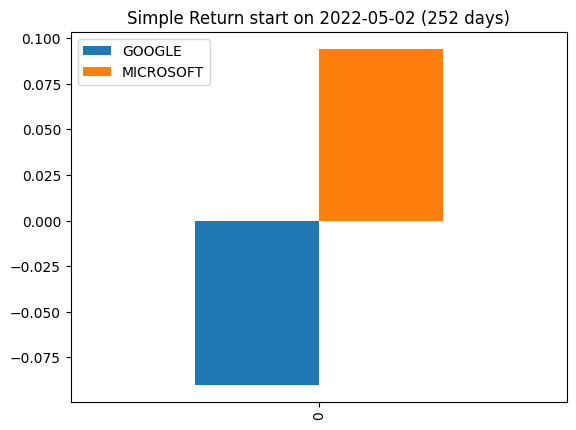

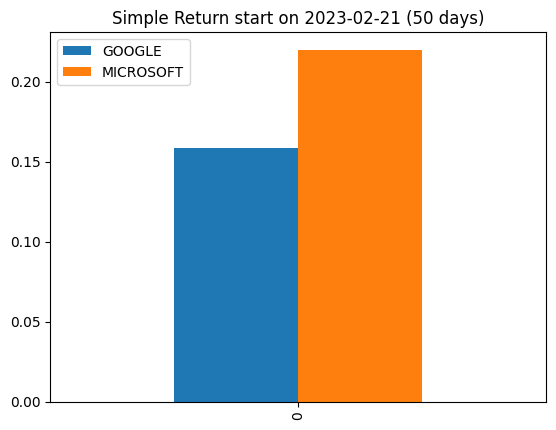

In [36]:
### Simple Return
# It is generally believed that a simple rate of returns is preferable when you have to deal with multiple assets over the same timeframe.

######################################################################################################################################################

## Overall
# Prepare DataFrame to store our results
combine_simpleReturn = pd.DataFrame(index=[0], columns=company_name)

# Stocks For Loops
for company, com_name in zip(company_list, company_name):
  # Calculation
  combine_simpleReturn[com_name] = (company['Adj Close'][-1] - company['Adj Close'][0]) / company['Adj Close'][0]
  
# Showing the plot
combine_simpleReturn.plot.bar(title=f"Simple Return start on {company_list[0].index[0].strftime('%Y-%m-%d')} ({len(company)} days)")

######################################################################################################################################################

## Different Timeframes
# Stocks For Loops
for company, com_name in zip(company_list, company_name):
  # Test from last 50 days of data
  company = company.tail(50)
  # Calculation
  combine_simpleReturn[com_name] = (company['Adj Close'][-1] - company['Adj Close'][0]) / company['Adj Close'][0]
  
# Showing the plot
combine_simpleReturn.plot.bar(title=f"Simple Return start on {company_list[0].tail(50).index[0].strftime('%Y-%m-%d')} (50 days)")

Start date: 2022-05-02


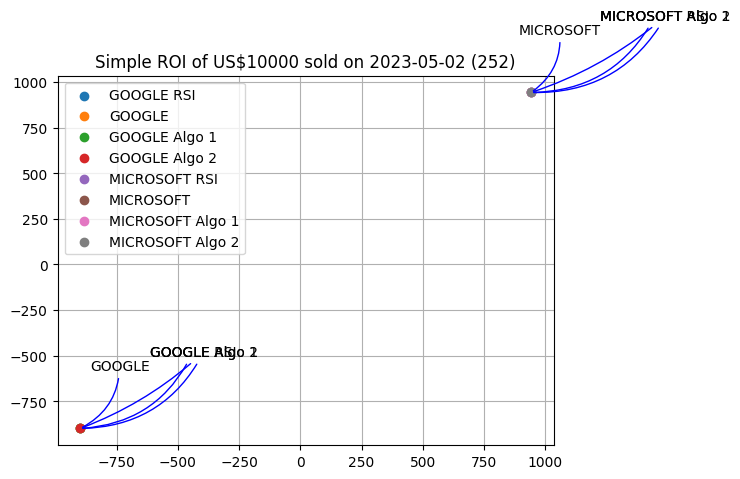

Start date: 2023-02-21


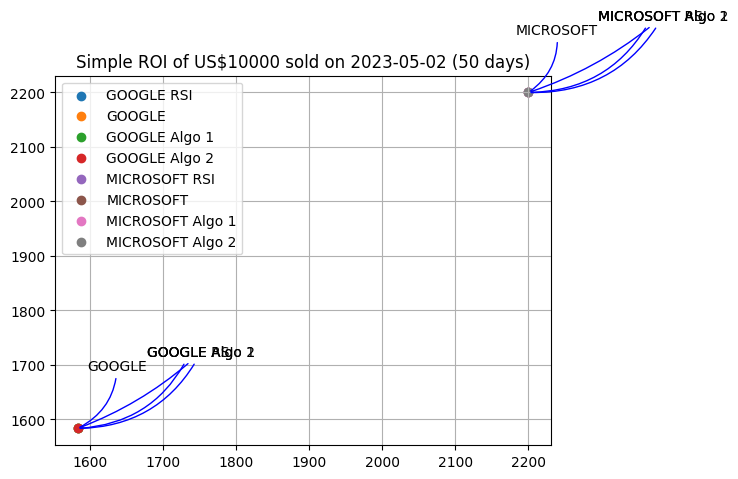

In [49]:
### Calculate Simple Return on investment of specified amount

# e.g. US$10,000
starting_amount = 10000
# Define sell day
last_date = company_list[0].index[-1].strftime('%Y-%m-%d')

######################################################################################################################################################

## Overall
# Prepare DataFrame to store our results
combine_simpleReturn_specifiedAmount = pd.DataFrame(index=[0], columns=company_name)

# Stocks For Loops
for company, com_name in zip(company_list, company_name):
  # Calculation
  combine_simpleReturn_specifiedAmount[com_name + ' RSI'] = combine_rsi['simple_return'][com_name]*starting_amount
  combine_simpleReturn_specifiedAmount[com_name] = ((company['Adj Close'][-1] - company['Adj Close'][0]) / company['Adj Close'][0])*starting_amount
  combine_simpleReturn_specifiedAmount[com_name + ' Algo 1'] = combine_algo1['simple_return'][com_name]*starting_amount
  combine_simpleReturn_specifiedAmount[com_name + ' Algo 2'] = combine_algo2['simple_return'][com_name]*starting_amount
  # Scatter plot setting
  plt.scatter(combine_simpleReturn_specifiedAmount[com_name + ' RSI'], combine_simpleReturn_specifiedAmount[com_name + ' RSI'], label='{0}'.format(com_name + ' RSI'))
  plt.annotate(f'{com_name} RSI', xy=(combine_simpleReturn_specifiedAmount[com_name + ' RSI'], combine_simpleReturn_specifiedAmount[com_name + ' RSI']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_simpleReturn_specifiedAmount[com_name], combine_simpleReturn_specifiedAmount[com_name], label='{0}'.format(com_name))
  plt.annotate(f'{com_name}', xy=(combine_simpleReturn_specifiedAmount[com_name], combine_simpleReturn_specifiedAmount[com_name]), xytext=(50, 50), textcoords='offset points', ha='right', va='top', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_simpleReturn_specifiedAmount[com_name + ' Algo 1'], combine_simpleReturn_specifiedAmount[com_name + ' Algo 1'], label='{0}'.format(com_name + ' Algo 1'))
  plt.annotate(f'{com_name} Algo 1', xy=(combine_simpleReturn_specifiedAmount[com_name + ' Algo 1'], combine_simpleReturn_specifiedAmount[com_name + ' Algo 1']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_simpleReturn_specifiedAmount[com_name + ' Algo 2'], combine_simpleReturn_specifiedAmount[com_name + ' Algo 2'], label='{0}'.format(com_name + ' Algo 2'))
  plt.annotate(f'{com_name} Algo 2', xy=(combine_simpleReturn_specifiedAmount[com_name + ' Algo 2'], combine_simpleReturn_specifiedAmount[com_name + ' Algo 2']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.1'))
  plt.legend()
  plt.grid(True)
  plt.title('Simple ROI of US${0} sold on {1} ({2})'.format(starting_amount, last_date, len(company)))

# Print out start date
print(f"Start date: {company_list[0].index[0].strftime('%Y-%m-%d')}")
# Showing the plot
plt.show()

######################################################################################################################################################

## Different Timeframes
# Stocks For Loops
for company, com_name in zip(company_list, company_name):
  # Test from last 50 days of data
  company = company.tail(50)
  # Calculation
  combine_simpleReturn_specifiedAmount[com_name] = ((company['Adj Close'][-1] - company['Adj Close'][0]) / company['Adj Close'][0])*starting_amount
  combine_simpleReturn_specifiedAmount[com_name + ' RSI'] = combine_rsi_50d['simple_return'][com_name]*starting_amount
  combine_simpleReturn_specifiedAmount[com_name + ' Algo 1'] = combine_algo1_50d['simple_return'][com_name]*starting_amount
  combine_simpleReturn_specifiedAmount[com_name + ' Algo 2'] = combine_algo2_50d['simple_return'][com_name]*starting_amount
  # Scatter plot setting
  plt.scatter(combine_simpleReturn_specifiedAmount[com_name + ' RSI'], combine_simpleReturn_specifiedAmount[com_name + ' RSI'], label='{0}'.format(com_name + ' RSI'))
  plt.annotate(f'{com_name} RSI', xy=(combine_simpleReturn_specifiedAmount[com_name + ' RSI'], combine_simpleReturn_specifiedAmount[com_name + ' RSI']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_simpleReturn_specifiedAmount[com_name], combine_simpleReturn_specifiedAmount[com_name], label='{0}'.format(com_name))
  plt.annotate(f'{com_name}', xy=(combine_simpleReturn_specifiedAmount[com_name], combine_simpleReturn_specifiedAmount[com_name]), xytext=(50, 50), textcoords='offset points', ha='right', va='top', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_simpleReturn_specifiedAmount[com_name + ' Algo 1'], combine_simpleReturn_specifiedAmount[com_name + ' Algo 1'], label='{0}'.format(com_name + ' Algo 1'))
  plt.annotate(f'{com_name} Algo 1', xy=(combine_simpleReturn_specifiedAmount[com_name + ' Algo 1'], combine_simpleReturn_specifiedAmount[com_name + ' Algo 1']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_simpleReturn_specifiedAmount[com_name + ' Algo 2'], combine_simpleReturn_specifiedAmount[com_name + ' Algo 2'], label='{0}'.format(com_name + ' Algo 2'))
  plt.annotate(f'{com_name} Algo 2', xy=(combine_simpleReturn_specifiedAmount[com_name + ' Algo 2'], combine_simpleReturn_specifiedAmount[com_name + ' Algo 2']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.1'))
  plt.legend()
  plt.grid(True)
  plt.title('Simple ROI of US${0} sold on {1} (50 days)'.format(starting_amount, last_date))

# Print out start date
print(f"Start date: {company_list[0].tail(50).index[0].strftime('%Y-%m-%d')}")
# Showing the plot
plt.show()

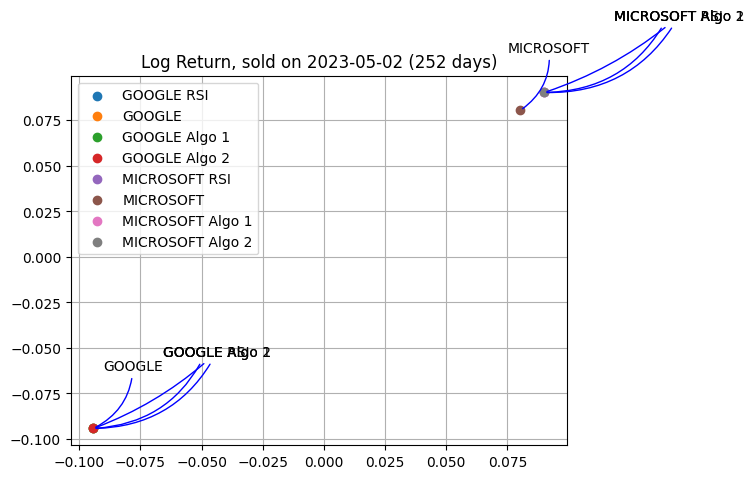

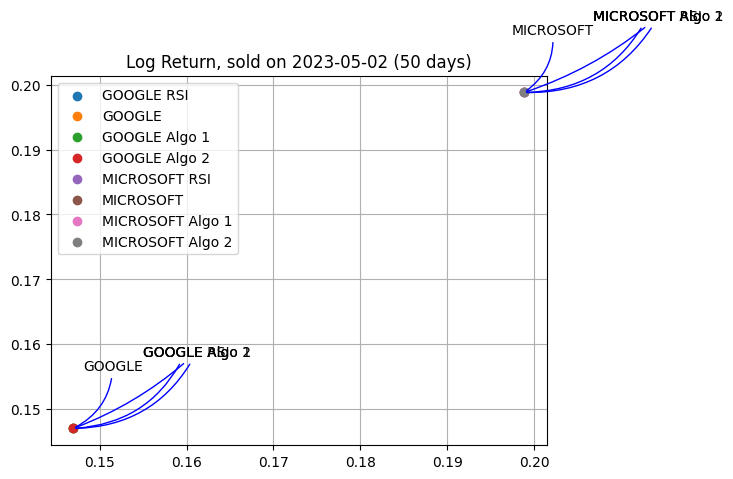

In [51]:
### Log Return

######################################################################################################################################################

## Overall
# Prepare DataFrame to store our results
combine_logReturn = pd.DataFrame(index=[0], columns=company_name)

# Stocks For Loops
for company, com_name in zip(company_list, company_name):
  # Calculation
  combine_logReturn[com_name + ' RSI'] = combine_rsi['log_return'][com_name]
  combine_logReturn[com_name] = np.log(company['Close'][-1] / company['Close'][0])
  combine_logReturn[com_name + ' Algo 1'] = combine_algo1['log_return'][com_name]
  combine_logReturn[com_name + ' Algo 2'] = combine_algo2['log_return'][com_name]
  # Scatter plot setting
  plt.scatter(combine_logReturn[com_name + ' RSI'], combine_logReturn[com_name + ' RSI'], label='{0}'.format(com_name + ' RSI'))
  plt.annotate(f'{com_name} RSI', xy=(combine_logReturn[com_name + ' RSI'], combine_logReturn[com_name + ' RSI']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_logReturn[com_name], combine_logReturn[com_name], label='{0}'.format(com_name))
  plt.annotate(f'{com_name}', xy=(combine_logReturn[com_name], combine_logReturn[com_name]), xytext=(50, 50), textcoords='offset points', ha='right', va='top', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_logReturn[com_name + ' Algo 1'], combine_logReturn[com_name + ' Algo 1'], label='{0}'.format(com_name + ' Algo 1'))
  plt.annotate(f'{com_name} Algo 1', xy=(combine_logReturn[com_name + ' Algo 1'], combine_logReturn[com_name + ' Algo 1']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_logReturn[com_name + ' Algo 2'], combine_logReturn[com_name + ' Algo 2'], label='{0}'.format(com_name + ' Algo 2'))
  plt.annotate(f'{com_name} Algo 2', xy=(combine_logReturn[com_name + ' Algo 2'], combine_logReturn[com_name + ' Algo 2']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.1'))
  plt.legend()
  plt.grid(True)
  plt.title('Log Return, sold on {0} ({1} days)'.format(last_date, len(company)))

# Showing the plot
plt.show()

######################################################################################################################################################

## Different Timeframes
# Stocks For Loops
for company, com_name in zip(company_list, company_name):
  # Test from last 50 days of data
  company = company.tail(50)
  # Calculation
  combine_logReturn[com_name + ' RSI'] = combine_rsi_50d['log_return'][com_name]
  combine_logReturn[com_name] = np.log(company['Close'][-1] / company['Close'][0])
  combine_logReturn[com_name + ' Algo 1'] = combine_algo1_50d['log_return'][com_name]
  combine_logReturn[com_name + ' Algo 2'] = combine_algo2_50d['log_return'][com_name]
  # Scatter plot setting
  plt.scatter(combine_logReturn[com_name + ' RSI'], combine_logReturn[com_name + ' RSI'], label='{0}'.format(com_name + ' RSI'))
  plt.annotate(f'{com_name} RSI', xy=(combine_logReturn[com_name + ' RSI'], combine_logReturn[com_name + ' RSI']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_logReturn[com_name], combine_logReturn[com_name], label='{0}'.format(com_name))
  plt.annotate(f'{com_name}', xy=(combine_logReturn[com_name], combine_logReturn[com_name]), xytext=(50, 50), textcoords='offset points', ha='right', va='top', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_logReturn[com_name + ' Algo 1'], combine_logReturn[com_name + ' Algo 1'], label='{0}'.format(com_name + ' Algo 1'))
  plt.annotate(f'{com_name} Algo 1', xy=(combine_logReturn[com_name + ' Algo 1'], combine_logReturn[com_name + ' Algo 1']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_logReturn[com_name + ' Algo 2'], combine_logReturn[com_name + ' Algo 2'], label='{0}'.format(com_name + ' Algo 2'))
  plt.annotate(f'{com_name} Algo 2', xy=(combine_logReturn[com_name + ' Algo 2'], combine_logReturn[com_name + ' Algo 2']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.1'))
  plt.legend()
  plt.grid(True)
  plt.title('Log Return, sold on {0} ({1} days)'.format(last_date, len(company)))

# Showing the plot
plt.show()

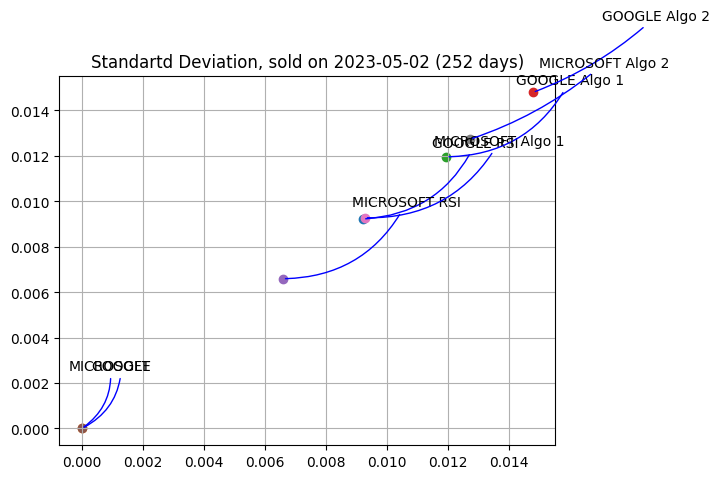

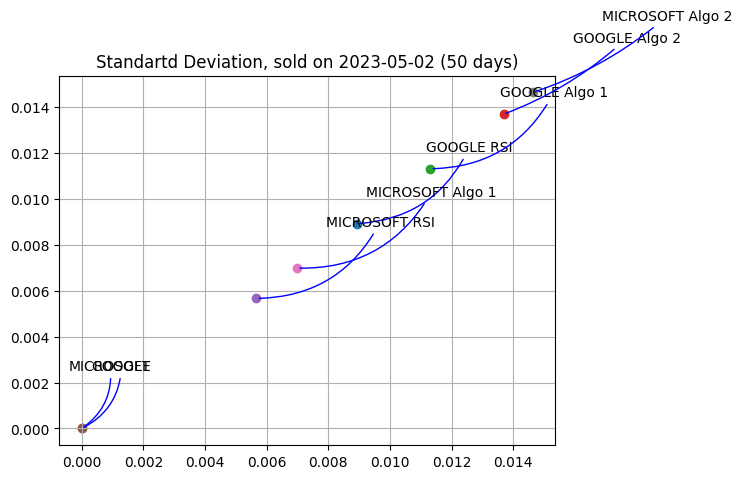

In [54]:
### Standard Deviation

######################################################################################################################################################

## Overall
# Prepare DataFrame to store our results
combine_sd = pd.DataFrame(index=[0], columns=company_name)

# Stocks For Loops
for company, com_name in zip(company_list, company_name):
  # Calculation
  combine_sd[com_name + ' RSI'] = combine_rsi['std_dev'][com_name]
  combine_sd[com_name] = (company['Close'][-1] / company['Close'][0]).std()
  combine_sd[com_name + ' Algo 1'] = combine_algo1['std_dev'][com_name]
  combine_sd[com_name + ' Algo 2'] = combine_algo2['std_dev'][com_name]
  # Scatter plot setting
  plt.scatter(combine_sd[com_name + ' RSI'], combine_sd[com_name + ' RSI'], label='Standard Deviation ({0})'.format(com_name + ' RSI'))
  plt.annotate(f'{com_name} RSI', xy=(combine_sd[com_name + ' RSI'], combine_sd[com_name + ' RSI']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_sd[com_name], combine_sd[com_name], label='Standard Deviation ({0})'.format(com_name))
  plt.annotate(f'{com_name}', xy=(combine_sd[com_name], combine_sd[com_name]), xytext=(50, 50), textcoords='offset points', ha='right', va='top', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_sd[com_name + ' Algo 1'], combine_sd[com_name + ' Algo 1'], label='Standard Deviation ({0})'.format(com_name + ' Algo 1'))
  plt.annotate(f'{com_name} Algo 1', xy=(combine_sd[com_name + ' Algo 1'], combine_sd[com_name + ' Algo 1']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_sd[com_name + ' Algo 2'], combine_sd[com_name + ' Algo 2'], label='Standard Deviation ({0})'.format(com_name + ' Algo 2'))
  plt.annotate(f'{com_name} Algo 2', xy=(combine_sd[com_name + ' Algo 2'], combine_sd[com_name + ' Algo 2']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.1'))
  # plt.legend()
  plt.grid(True)
  plt.title('Standartd Deviation, sold on {0} ({1} days)'.format(last_date, len(company)))

# Showing the plot
plt.show()

######################################################################################################################################################

## Different Timeframes
# Stocks For Loops
for company, com_name in zip(company_list, company_name):
  # Test from last 50 days of data
  company = company.tail(50)
  # Calculation
  combine_sd[com_name + ' RSI'] = combine_rsi_50d['std_dev'][com_name]
  combine_sd[com_name] = (company['Close'][-1] / company['Close'][0]).std()
  combine_sd[com_name + ' Algo 1'] = combine_algo1_50d['std_dev'][com_name]
  combine_sd[com_name + ' Algo 2'] = combine_algo2_50d['std_dev'][com_name]
  # Scatter plot setting
  plt.scatter(combine_sd[com_name + ' RSI'], combine_sd[com_name + ' RSI'], label='Standard Deviation ({0})'.format(com_name + ' RSI'))
  plt.annotate(f'{com_name} RSI', xy=(combine_sd[com_name + ' RSI'], combine_sd[com_name + ' RSI']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_sd[com_name], combine_sd[com_name], label='Standard Deviation ({0})'.format(com_name))
  plt.annotate(f'{com_name}', xy=(combine_sd[com_name], combine_sd[com_name]), xytext=(50, 50), textcoords='offset points', ha='right', va='top', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_sd[com_name + ' Algo 1'], combine_sd[com_name + ' Algo 1'], label='Standard Deviation ({0})'.format(com_name + ' Algo 1'))
  plt.annotate(f'{com_name} Algo 1', xy=(combine_sd[com_name + ' Algo 1'], combine_sd[com_name + ' Algo 1']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_sd[com_name + ' Algo 2'], combine_sd[com_name + ' Algo 2'], label='Standard Deviation ({0})'.format(com_name + ' Algo 2'))
  plt.annotate(f'{com_name} Algo 2', xy=(combine_sd[com_name + ' Algo 2'], combine_sd[com_name + ' Algo 2']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.1'))
  # plt.legend()
  plt.grid(True)
  plt.title('Standartd Deviation, sold on {0} ({1} days)'.format(last_date, len(company)))

# Showing the plot
plt.show()

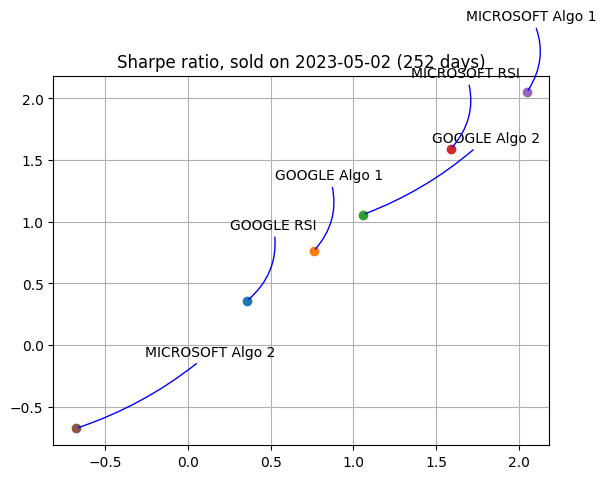

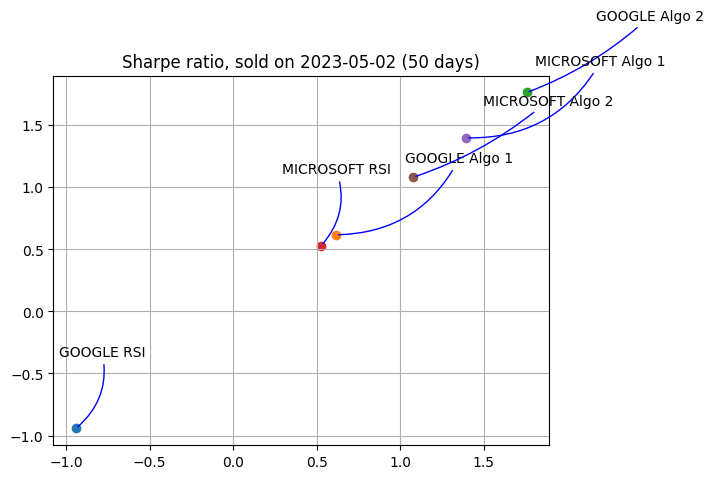

In [58]:
### Calculate the Sharpe ratio

######################################################################################################################################################

## Overall
# Prepare DataFrame to store our results
combine_sharpe = pd.DataFrame(index=[0], columns=company_name)

# Stocks For Loops
for company, com_name in zip(company_list, company_name):
  # Calculation
  combine_sharpe[com_name + ' RSI'] = combine_rsi['sharpe_ratio'][com_name]
  combine_sharpe[com_name + ' Algo 1'] = combine_algo1['sharpe_ratio'][com_name]
  combine_sharpe[com_name + ' Algo 2'] = combine_algo2['sharpe_ratio'][com_name]
  # Scatter plot setting
  plt.scatter(combine_sharpe[com_name + ' RSI'], combine_sharpe[com_name + ' RSI'], label='Sharpe Ratio ({0})'.format(com_name + ' RSI'))
  plt.annotate(f'{com_name} RSI', xy=(combine_sharpe[com_name + ' RSI'], combine_sharpe[com_name + ' RSI']), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_sharpe[com_name + ' Algo 1'], combine_sharpe[com_name + ' Algo 1'], label='Sharpe Ratio ({0})'.format(com_name + ' Algo 1'))
  plt.annotate(f'{com_name} Algo 1', xy=(combine_sharpe[com_name + ' Algo 1'], combine_sharpe[com_name + ' Algo 1']), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_sharpe[com_name + ' Algo 2'], combine_sharpe[com_name + ' Algo 2'], label='Sharpe Ratio ({0})'.format(com_name + ' Algo 2'))
  plt.annotate(f'{com_name} Algo 2', xy=(combine_sharpe[com_name + ' Algo 2'], combine_sharpe[com_name + ' Algo 2']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.1'))
  # plt.legend()
  plt.grid(True)
  plt.title('Sharpe ratio, sold on {0} ({1} days)'.format(last_date, len(company)))

# Showing the plot
plt.show()

######################################################################################################################################################

## Different Timeframes
# Stocks For Loops
for company, com_name in zip(company_list, company_name):
  # Test from last 50 days of data
  company = company.tail(50)
  # Calculation
  combine_sharpe[com_name + ' RSI'] = combine_rsi_50d['sharpe_ratio'][com_name]
  combine_sharpe[com_name + ' Algo 1'] = combine_algo1_50d['sharpe_ratio'][com_name]
  combine_sharpe[com_name + ' Algo 2'] = combine_algo2_50d['sharpe_ratio'][com_name]
  # Scatter plot setting
  plt.scatter(combine_sharpe[com_name + ' RSI'], combine_sharpe[com_name + ' RSI'], label='Sharpe Ratio ({0})'.format(com_name + ' RSI'))
  plt.annotate(f'{com_name} RSI', xy=(combine_sharpe[com_name + ' RSI'], combine_sharpe[com_name + ' RSI']), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_sharpe[com_name + ' Algo 1'], combine_sharpe[com_name + ' Algo 1'], label='Sharpe Ratio ({0})'.format(com_name + ' Algo 1'))
  plt.annotate(f'{com_name} Algo 1', xy=(combine_sharpe[com_name + ' Algo 1'], combine_sharpe[com_name + ' Algo 1']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_sharpe[com_name + ' Algo 2'], combine_sharpe[com_name + ' Algo 2'], label='Sharpe Ratio ({0})'.format(com_name + ' Algo 2'))
  plt.annotate(f'{com_name} Algo 2', xy=(combine_sharpe[com_name + ' Algo 2'], combine_sharpe[com_name + ' Algo 2']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.1'))
  # plt.legend()
  plt.grid(True)
  plt.title('Sharpe ratio, sold on {0} ({1} days)'.format(last_date, len(company)))

# Showing the plot
plt.show()

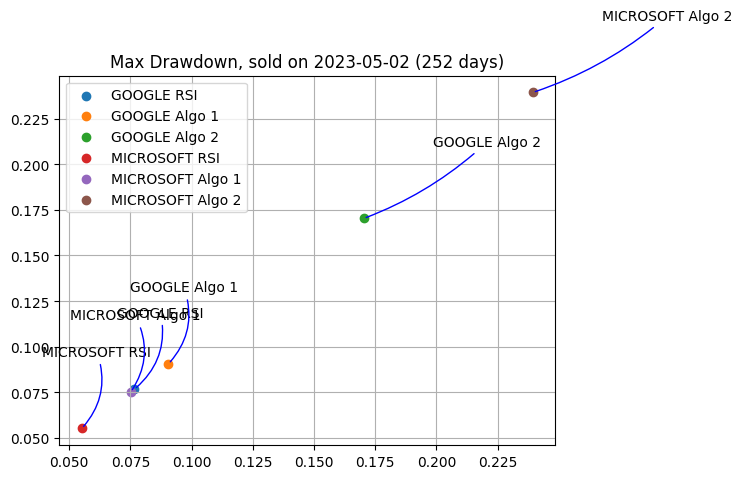

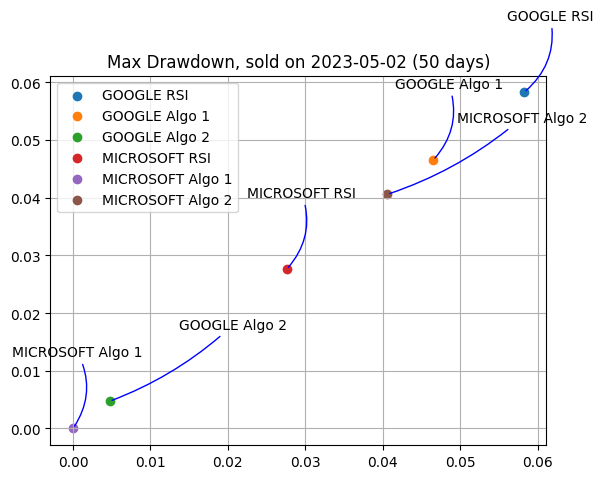

In [59]:
### Calculate the Maximum Drawdown

######################################################################################################################################################

## Overall
# Prepare DataFrame to store our results
combine_drawdown = pd.DataFrame(index=[0], columns=company_name)

# Stocks For Loops
for company, com_name in zip(company_list, company_name):
  # Calculation
  combine_drawdown[com_name + ' RSI'] = combine_rsi['max_drawdown'][com_name]
  combine_drawdown[com_name + ' Algo 1'] = combine_algo1['max_drawdown'][com_name]
  combine_drawdown[com_name + ' Algo 2'] = combine_algo2['max_drawdown'][com_name]
  # Scatter plot setting
  plt.scatter(combine_drawdown[com_name + ' RSI'], combine_drawdown[com_name + ' RSI'], label=f'{com_name} RSI')
  plt.annotate(f'{com_name} RSI', xy=(combine_drawdown[com_name + ' RSI'], combine_drawdown[com_name + ' RSI']), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_drawdown[com_name + ' Algo 1'], combine_drawdown[com_name + ' Algo 1'], label=f'{com_name} Algo 1')
  plt.annotate(f'{com_name} Algo 1', xy=(combine_drawdown[com_name + ' Algo 1'], combine_drawdown[com_name + ' Algo 1']), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_drawdown[com_name + ' Algo 2'], combine_drawdown[com_name + ' Algo 2'], label=f'{com_name} Algo 2')
  plt.annotate(f'{com_name} Algo 2', xy=(combine_drawdown[com_name + ' Algo 2'], combine_drawdown[com_name + ' Algo 2']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.1'))
  plt.legend()
  plt.grid(True)
  plt.title('Max Drawdown, sold on {0} ({1} days)'.format(last_date, len(company)))

# Showing the plot
plt.show()

######################################################################################################################################################

## Different Timeframes
# Stocks For Loops
for company, com_name in zip(company_list, company_name):
  # Test from last 50 days of data
  company = company.tail(50)
  # Calculation
  combine_drawdown[com_name + ' RSI'] = combine_rsi_50d['max_drawdown'][com_name]
  combine_drawdown[com_name + ' Algo 1'] = combine_algo1_50d['max_drawdown'][com_name]
  combine_drawdown[com_name + ' Algo 2'] = combine_algo2_50d['max_drawdown'][com_name]
  # Scatter plot setting
  plt.scatter(combine_drawdown[com_name + ' RSI'], combine_drawdown[com_name + ' RSI'], label=f'{com_name} RSI')
  plt.annotate(f'{com_name} RSI', xy=(combine_drawdown[com_name + ' RSI'], combine_drawdown[com_name + ' RSI']), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_drawdown[com_name + ' Algo 1'], combine_drawdown[com_name + ' Algo 1'], label=f'{com_name} Algo 1')
  plt.annotate(f'{com_name} Algo 1', xy=(combine_drawdown[com_name + ' Algo 1'], combine_drawdown[com_name + ' Algo 1']), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_drawdown[com_name + ' Algo 2'], combine_drawdown[com_name + ' Algo 2'], label=f'{com_name} Algo 2')
  plt.annotate(f'{com_name} Algo 2', xy=(combine_drawdown[com_name + ' Algo 2'], combine_drawdown[com_name + ' Algo 2']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.1'))
  plt.legend()
  plt.grid(True)
  plt.title('Max Drawdown, sold on {0} ({1} days)'.format(last_date, len(company)))

# Showing the plot
plt.show()

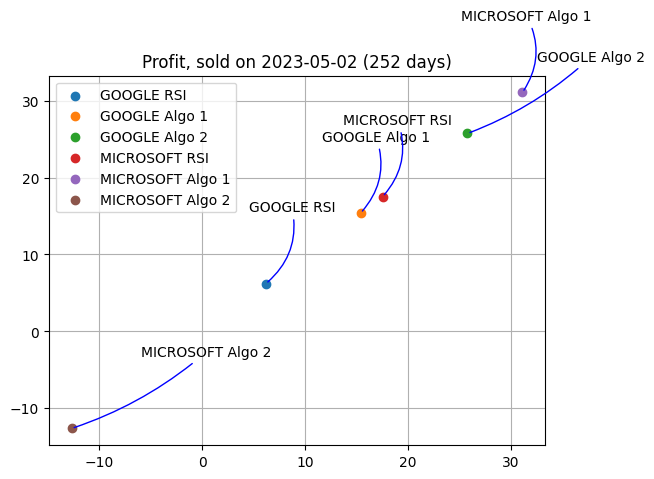

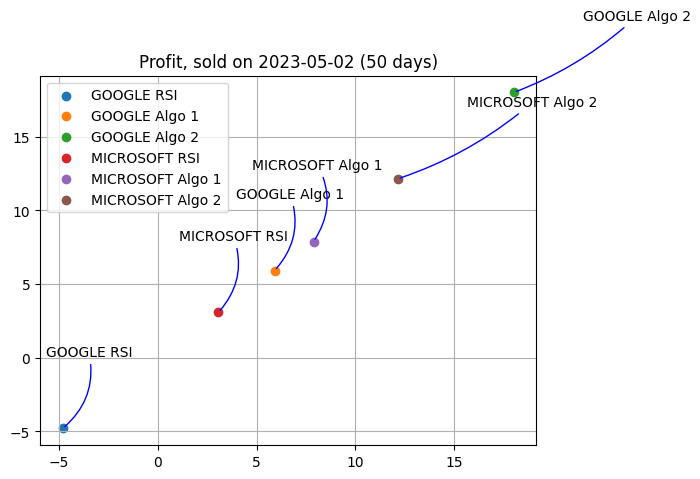

In [60]:
### Calculate the Profit

######################################################################################################################################################

## Overall
# Prepare DataFrame to store our results
combine_profit = pd.DataFrame(index=[0], columns=company_name)

# Stocks For Loops
for company, com_name in zip(company_list, company_name):
  # Calculation
  combine_profit[com_name + ' RSI'] = combine_rsi['profit'][com_name]
  combine_profit[com_name + ' Algo 1'] = combine_algo1['profit'][com_name]
  combine_profit[com_name + ' Algo 2'] = combine_algo2['profit'][com_name]
  # Scatter plot setting
  plt.scatter(combine_profit[com_name + ' RSI'], combine_profit[com_name + ' RSI'], label=f'{com_name} RSI')
  plt.annotate(f'{com_name} RSI', xy=(combine_profit[com_name + ' RSI'], combine_profit[com_name + ' RSI']), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_profit[com_name + ' Algo 1'], combine_profit[com_name + ' Algo 1'], label=f'{com_name} Algo 1')
  plt.annotate(f'{com_name} Algo 1', xy=(combine_profit[com_name + ' Algo 1'], combine_profit[com_name + ' Algo 1']), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_profit[com_name + ' Algo 2'], combine_profit[com_name + ' Algo 2'], label=f'{com_name} Algo 2')
  plt.annotate(f'{com_name} Algo 2', xy=(combine_profit[com_name + ' Algo 2'], combine_profit[com_name + ' Algo 2']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.1'))
  plt.legend()
  plt.grid(True)
  plt.title('Profit, sold on {0} ({1} days)'.format(last_date, len(company)))

# Showing the plot
plt.show()

######################################################################################################################################################

## Different Timeframes
# Stocks For Loops
for company, com_name in zip(company_list, company_name):
  # Test from last 50 days of data
  company = company.tail(50)
  # Calculation
  combine_profit[com_name + ' RSI'] = combine_rsi_50d['profit'][com_name]
  combine_profit[com_name + ' Algo 1'] = combine_algo1_50d['profit'][com_name]
  combine_profit[com_name + ' Algo 2'] = combine_algo2_50d['profit'][com_name]
  # Scatter plot setting
  plt.scatter(combine_profit[com_name + ' RSI'], combine_profit[com_name + ' RSI'], label=f'{com_name} RSI')
  plt.annotate(f'{com_name} RSI', xy=(combine_profit[com_name + ' RSI'], combine_profit[com_name + ' RSI']), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_profit[com_name + ' Algo 1'], combine_profit[com_name + ' Algo 1'], label=f'{com_name} Algo 1')
  plt.annotate(f'{com_name} Algo 1', xy=(combine_profit[com_name + ' Algo 1'], combine_profit[com_name + ' Algo 1']), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
  plt.scatter(combine_profit[com_name + ' Algo 2'], combine_profit[com_name + ' Algo 2'], label=f'{com_name} Algo 2')
  plt.annotate(f'{com_name} Algo 2', xy=(combine_profit[com_name + ' Algo 2'], combine_profit[com_name + ' Algo 2']), xytext=(50, 50), textcoords='offset points', ha='left', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.1'))
  plt.legend()
  plt.grid(True)
  plt.title('Profit, sold on {0} ({1} days)'.format(last_date, len(company)))

# Showing the plot
plt.show()